# **Experiment Notebook**



## Context


### 0. Import Packages

In [79]:
# ! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [81]:
import copy
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [123]:
# !pip install imbalanced-learn

### 1.   Load Dataset

In [82]:
file_url = 'dataset/repurchase_dataset.csv'

In [83]:
df = pd.read_csv(file_url)


### 2. Explore Dataset

In [84]:
df.head(5)

,ID,Target,age_band,gender,car_model,car_segment,age_of_vehicle_years,sched_serv_warr,non_sched_serv_warr,sched_serv_paid,non_sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,annualised_mileage,num_dealers_visited,num_serv_dealer_purchased
0,1,0,3. 35 to 44,Male,model_1,LCV,9,2,10,3,7,5,6,9,8,10,4
1,2,0,NaN,NaN,model_2,Small/Medium,6,10,3,10,4,9,10,6,10,7,10
2,3,0,NaN,Male,model_3,Large/SUV,9,10,9,10,9,10,10,7,10,6,10
3,5,0,NaN,NaN,model_3,Large/SUV,5,8,5,8,4,5,6,4,10,9,7
4,6,0,NaN,Female,model_2,Small/Medium,8,9,4,10,7,9,8,5,4,4,9


In [85]:
df.columns

Index(['ID', 'Target', 'age_band', 'gender', 'car_model', 'car_segment',
       'age_of_vehicle_years', 'sched_serv_warr', 'non_sched_serv_warr',
       'sched_serv_paid', 'non_sched_serv_paid', 'total_paid_services',
       'total_services', 'mth_since_last_serv', 'annualised_mileage',
       'num_dealers_visited', 'num_serv_dealer_purchased'],
      dtype='object')

In [86]:
df.shape

(131337, 17)

In [87]:
df.describe()

,ID,Target,age_of_vehicle_years,sched_serv_warr,non_sched_serv_warr,sched_serv_paid,non_sched_serv_paid,total_paid_services,total_services,mth_since_last_serv,annualised_mileage,num_dealers_visited,num_serv_dealer_purchased
count,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000,131337.000000
mean,77097.384180,0.026809,5.493022,5.452500,5.472517,5.452287,5.497050,5.481692,5.454967,5.469807,5.502836,5.485438,5.480778
std,44501.636704,0.161525,2.843299,2.884328,2.870665,2.886528,2.878699,2.880408,2.875961,2.859756,2.854896,2.876772,2.867524
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,38563.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,77132.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,115668.000000,0.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,154139.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [88]:
df.isna().sum()

ID                                0
Target                            0
age_band                     112375
gender                        69308
car_model                         0
car_segment                       0
age_of_vehicle_years              0
sched_serv_warr                   0
non_sched_serv_warr               0
sched_serv_paid                   0
non_sched_serv_paid               0
total_paid_services               0
total_services                    0
mth_since_last_serv               0
annualised_mileage                0
num_dealers_visited               0
num_serv_dealer_purchased         0
dtype: int64

### 3. Explore Target variable

In [89]:
target = 'Target'

In [90]:
def custom_axes(ax, title='', xlabel='', ylabel=''):
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 5)

    ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# plot count
def plot_count(df, feat, figsize=(9, 3), title='', xlabel='', ylabel='', orientation='v', 
               ax='', mode='plot', order=[], ticklabels={}, bar_w = 1):
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize) 

    # get new tick labels if available
    ordered_ticklabels = [ticklabels[l] for l in order] if ticklabels != {} else order

    if orientation == 'v':
        sns.countplot(ax=ax, data=df, x=feat, order=order, width=bar_w)
        ax.set_xticklabels(ordered_ticklabels)
    else:
        sns.countplot(ax=ax, data=df, y=feat, order=order, width=bar_w)
        ax.set_yticklabels(ordered_ticklabels)

    # Add labels to each bar using ax.bar_label
    for container in ax.containers:
        ax.bar_label(container)
        
    custom_axes(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)   

    plt.show()

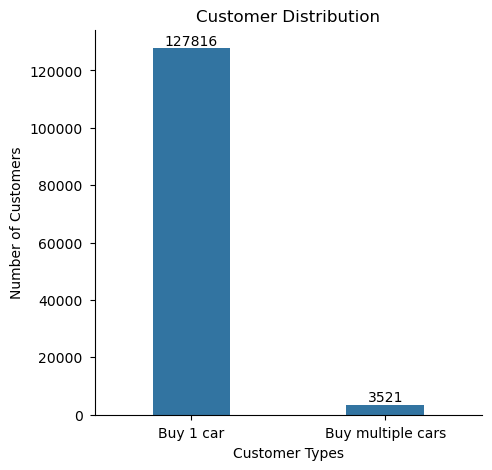

In [91]:
feat = target
prefix = f"Customer Distribution"
order = df[target].value_counts().index

labels = {'0': 'Buy 1 car', '1': 'Buy multiple cars'}

plot_count(df=df, feat=feat, title=f'{prefix}', xlabel='Customer Types', ylabel='Number of Customers', 
           bar_w=0.4, orientation='v', order=labels.keys(), ticklabels=labels, figsize=(5, 5))

In [92]:
print('Rebuy Customers Percentage:', round((len(df[df[target] == 1]) / len(df)*100), 3),'%')

Rebuy Customers Percentage: 2.681 %


There is a heavy imbalance in the dataset, where number of rebuy customers only accounts for nearly 3% in total.

### 4. Explore Variables of Interest

In [93]:
df.columns

Index(['ID', 'Target', 'age_band', 'gender', 'car_model', 'car_segment',
       'age_of_vehicle_years', 'sched_serv_warr', 'non_sched_serv_warr',
       'sched_serv_paid', 'non_sched_serv_paid', 'total_paid_services',
       'total_services', 'mth_since_last_serv', 'annualised_mileage',
       'num_dealers_visited', 'num_serv_dealer_purchased'],
      dtype='object')

In [94]:
cate_feats = ['age_band', 'gender', 'car_model', 'car_segment']
num_feats = ['age_of_vehicle_years', 'sched_serv_warr', 'non_sched_serv_warr',
       'sched_serv_paid', 'non_sched_serv_paid', 'total_paid_services',
       'total_services', 'mth_since_last_serv', 'annualised_mileage',
       'num_dealers_visited', 'num_serv_dealer_purchased']

#### Categorical Features

In [95]:
df[cate_feats].isna().sum()

age_band       112375
gender          69308
car_model           0
car_segment         0
dtype: int64

age_band and gender contain lots of missing values, which can be ignored in latter model development phrase.

In [96]:

# plot top k for categorial features with many unique values
def plot_bars(df, feat, figsize=(9, 3), title='', xlabel='', ylabel='', orientation='h',
               ax='', mode='plot', topk=5, bar_w=1, x_rotation=0, y_rotation=0, kind='norminal'):
    # if plot single figure
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize) 

    if kind == 'ordinal':
        # define colors
        pallete = sns.color_palette("rocket")
    elif kind == 'norminal':
        pallete = sns.color_palette("tab10")

    # sort df by value counts
    df = df[feat].value_counts().head(topk)

    if orientation == 'h':
        sns.barplot(ax=ax, x=df.values, y=df.index, orient='h', order=df.index,
                    palette=pallete, width=bar_w)
    else:
        sns.barplot(ax=ax, y=df.values, x=df.index, order=df.index,
                    palette=pallete, width=bar_w)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=y_rotation)

    # Add labels to each bar using ax.bar_label
    for container in ax.containers:
        ax.bar_label(container)
    
    custom_axes(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)   

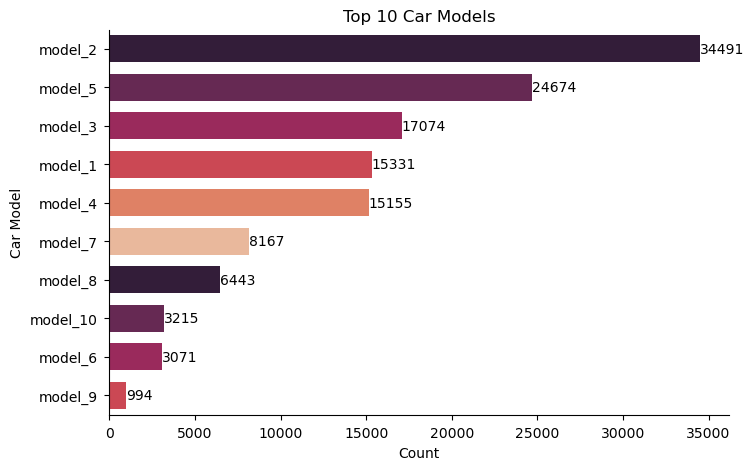

In [97]:
feat = 'car_model'
topk = 10
prefix = f"Top {topk} Car Models"

plot_bars(df=df, feat=feat, title=f'{prefix}', ylabel='Car Model', 
          xlabel='Count', topk=topk, bar_w=0.7, figsize=(8, 5), kind='ordinal')

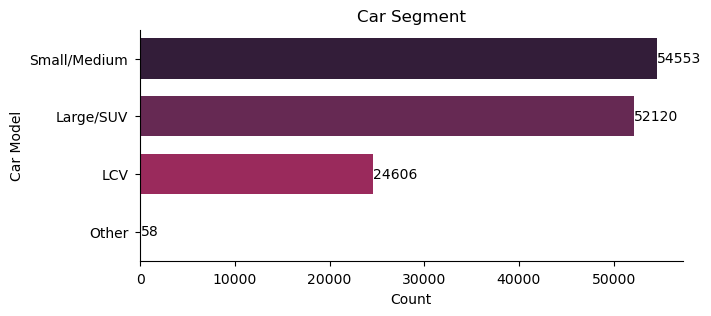

In [98]:
feat = 'car_segment'
topk = 10
prefix = f"Car Segment"

plot_bars(df=df, feat=feat, title=f'{prefix}', ylabel='Car Model', 
          xlabel='Count', topk=topk, bar_w=0.7, figsize=(7, 3), kind='ordinal')

In [99]:
import math 

def cal_cate_percent(df, col, order):
  percents = []

  data_len = len(df)

  for label in order[:-1]:
    count = len(df[df[col] == label])
    percents.append(round(count/data_len, 2)*100)

  # ensure sum = 1
  last_count = len(df[df[col] == order[-1]])
  percents.append(round(last_count/data_len, 2)*100)

  return percents


def plot_pies(df, feat, figsize=(6,6), prefix='', bbox_to_anchor=(-0.3, .5), 
              wspace=0.4, hspace=0.35):
  df_yes = df[df[target] == 1]
  df_no = df[df[target] == 0]

  fig, axes = plt.subplots(1, 2, figsize = (figsize[1], figsize[0]*2))
  color_palette = sns.color_palette("Paired")

  # reorder label in pie chart
  label_order = df[feat].value_counts().index

  # calculate percentage list
  percent_ls_yes = cal_cate_percent(df_yes, feat, label_order)
  percent_ls_no = cal_cate_percent(df_no, feat, label_order)

  labels_yes = [f'{l}: {s:0.1f}%' for l, s in zip(label_order, percent_ls_yes)]
  labels_no = [f'{l}: {s:0.1f}%' for l, s in zip(label_order, percent_ls_no)]

  # plot figure
  # axes[row_idx, col_idx].pie(percent_ls_yes, labels=label_order, colors=color_palette)
  axes[0].pie(percent_ls_yes, colors=color_palette)
  # bbox_to_anchor=(0.35, .5)
  axes[0].legend(labels_yes, loc='center left',
                                bbox_to_anchor=bbox_to_anchor, fontsize=9)

  # set figure title
  axes[0].set_title(f'{prefix} Distribution in Re-Buy Customer Group')

  # plot figure
  axes[1].pie(percent_ls_no, colors=color_palette)
  axes[1].legend(labels_no, loc='center left',
                                bbox_to_anchor=bbox_to_anchor, fontsize=9)
  # set figure title
  axes[1].set_title(f'{prefix} Distribution in Non-Re-Buy Customer Group')

  # # adjust distance between figures
  plt.subplots_adjust(wspace=wspace,
                    hspace=hspace)

  plt.show()

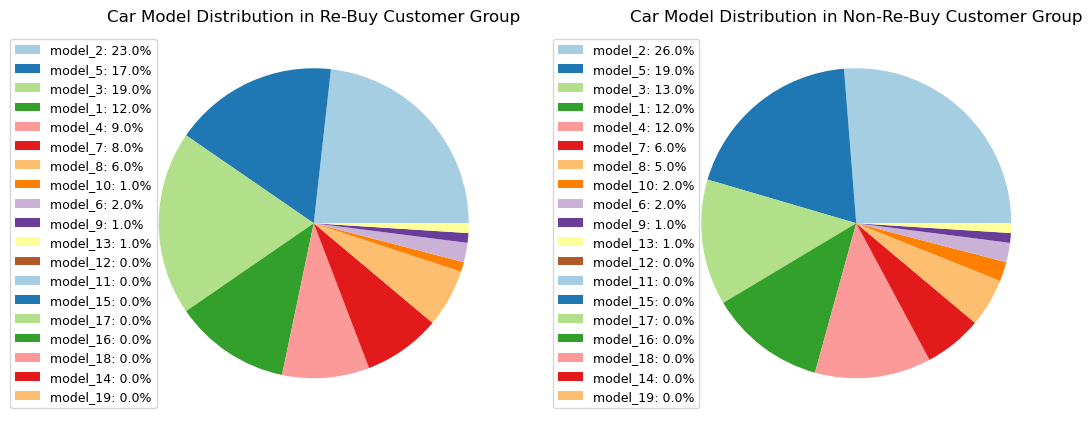

In [100]:
plot_pies(df=df, feat='car_model', figsize=(12,12), prefix='Car Model')

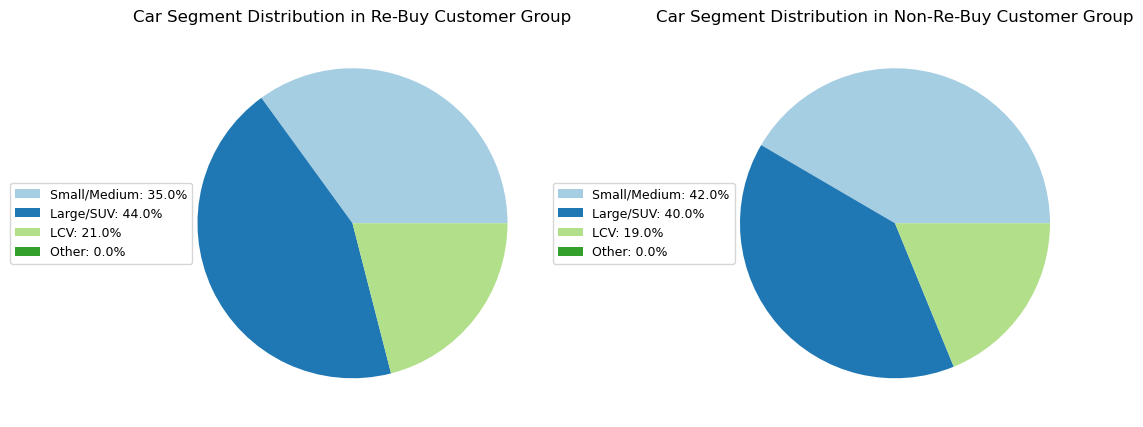

In [101]:
plot_pies(df=df, feat='car_segment', figsize=(12,12), prefix='Car Segment', bbox_to_anchor=(-0.4, 0.5))

There are slightly differences in car model and segment distributions in Rebuy Customer group and Non-Rebuy Customer group, which can be utilized to build classification model.

#### Numerical Features

In [102]:
# Define a function to calculate percentages within each class of feature2
def calculate_percentages(data, feature1, feature2):
  grouped_data = data.groupby([feature1, feature2])[feature1].count().unstack(fill_value=0)
  total_counts = grouped_data.sum(axis=1)
  percentages = grouped_data.div(total_counts, axis=0) * 100
  return percentages


def plot_hist(df, feat, bins=35, figsize=(9, 3), title='', xlabel='', ylabel='', ax='',
              format_legend=False, mode='plot'):
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df, x=feat, ax=ax, hue='Target', bins=bins, multiple="dodge", 
                 shrink=.8, stat='percent', common_norm=False)

    custom_axes(ax, title=title, xlabel=xlabel, ylabel=ylabel)

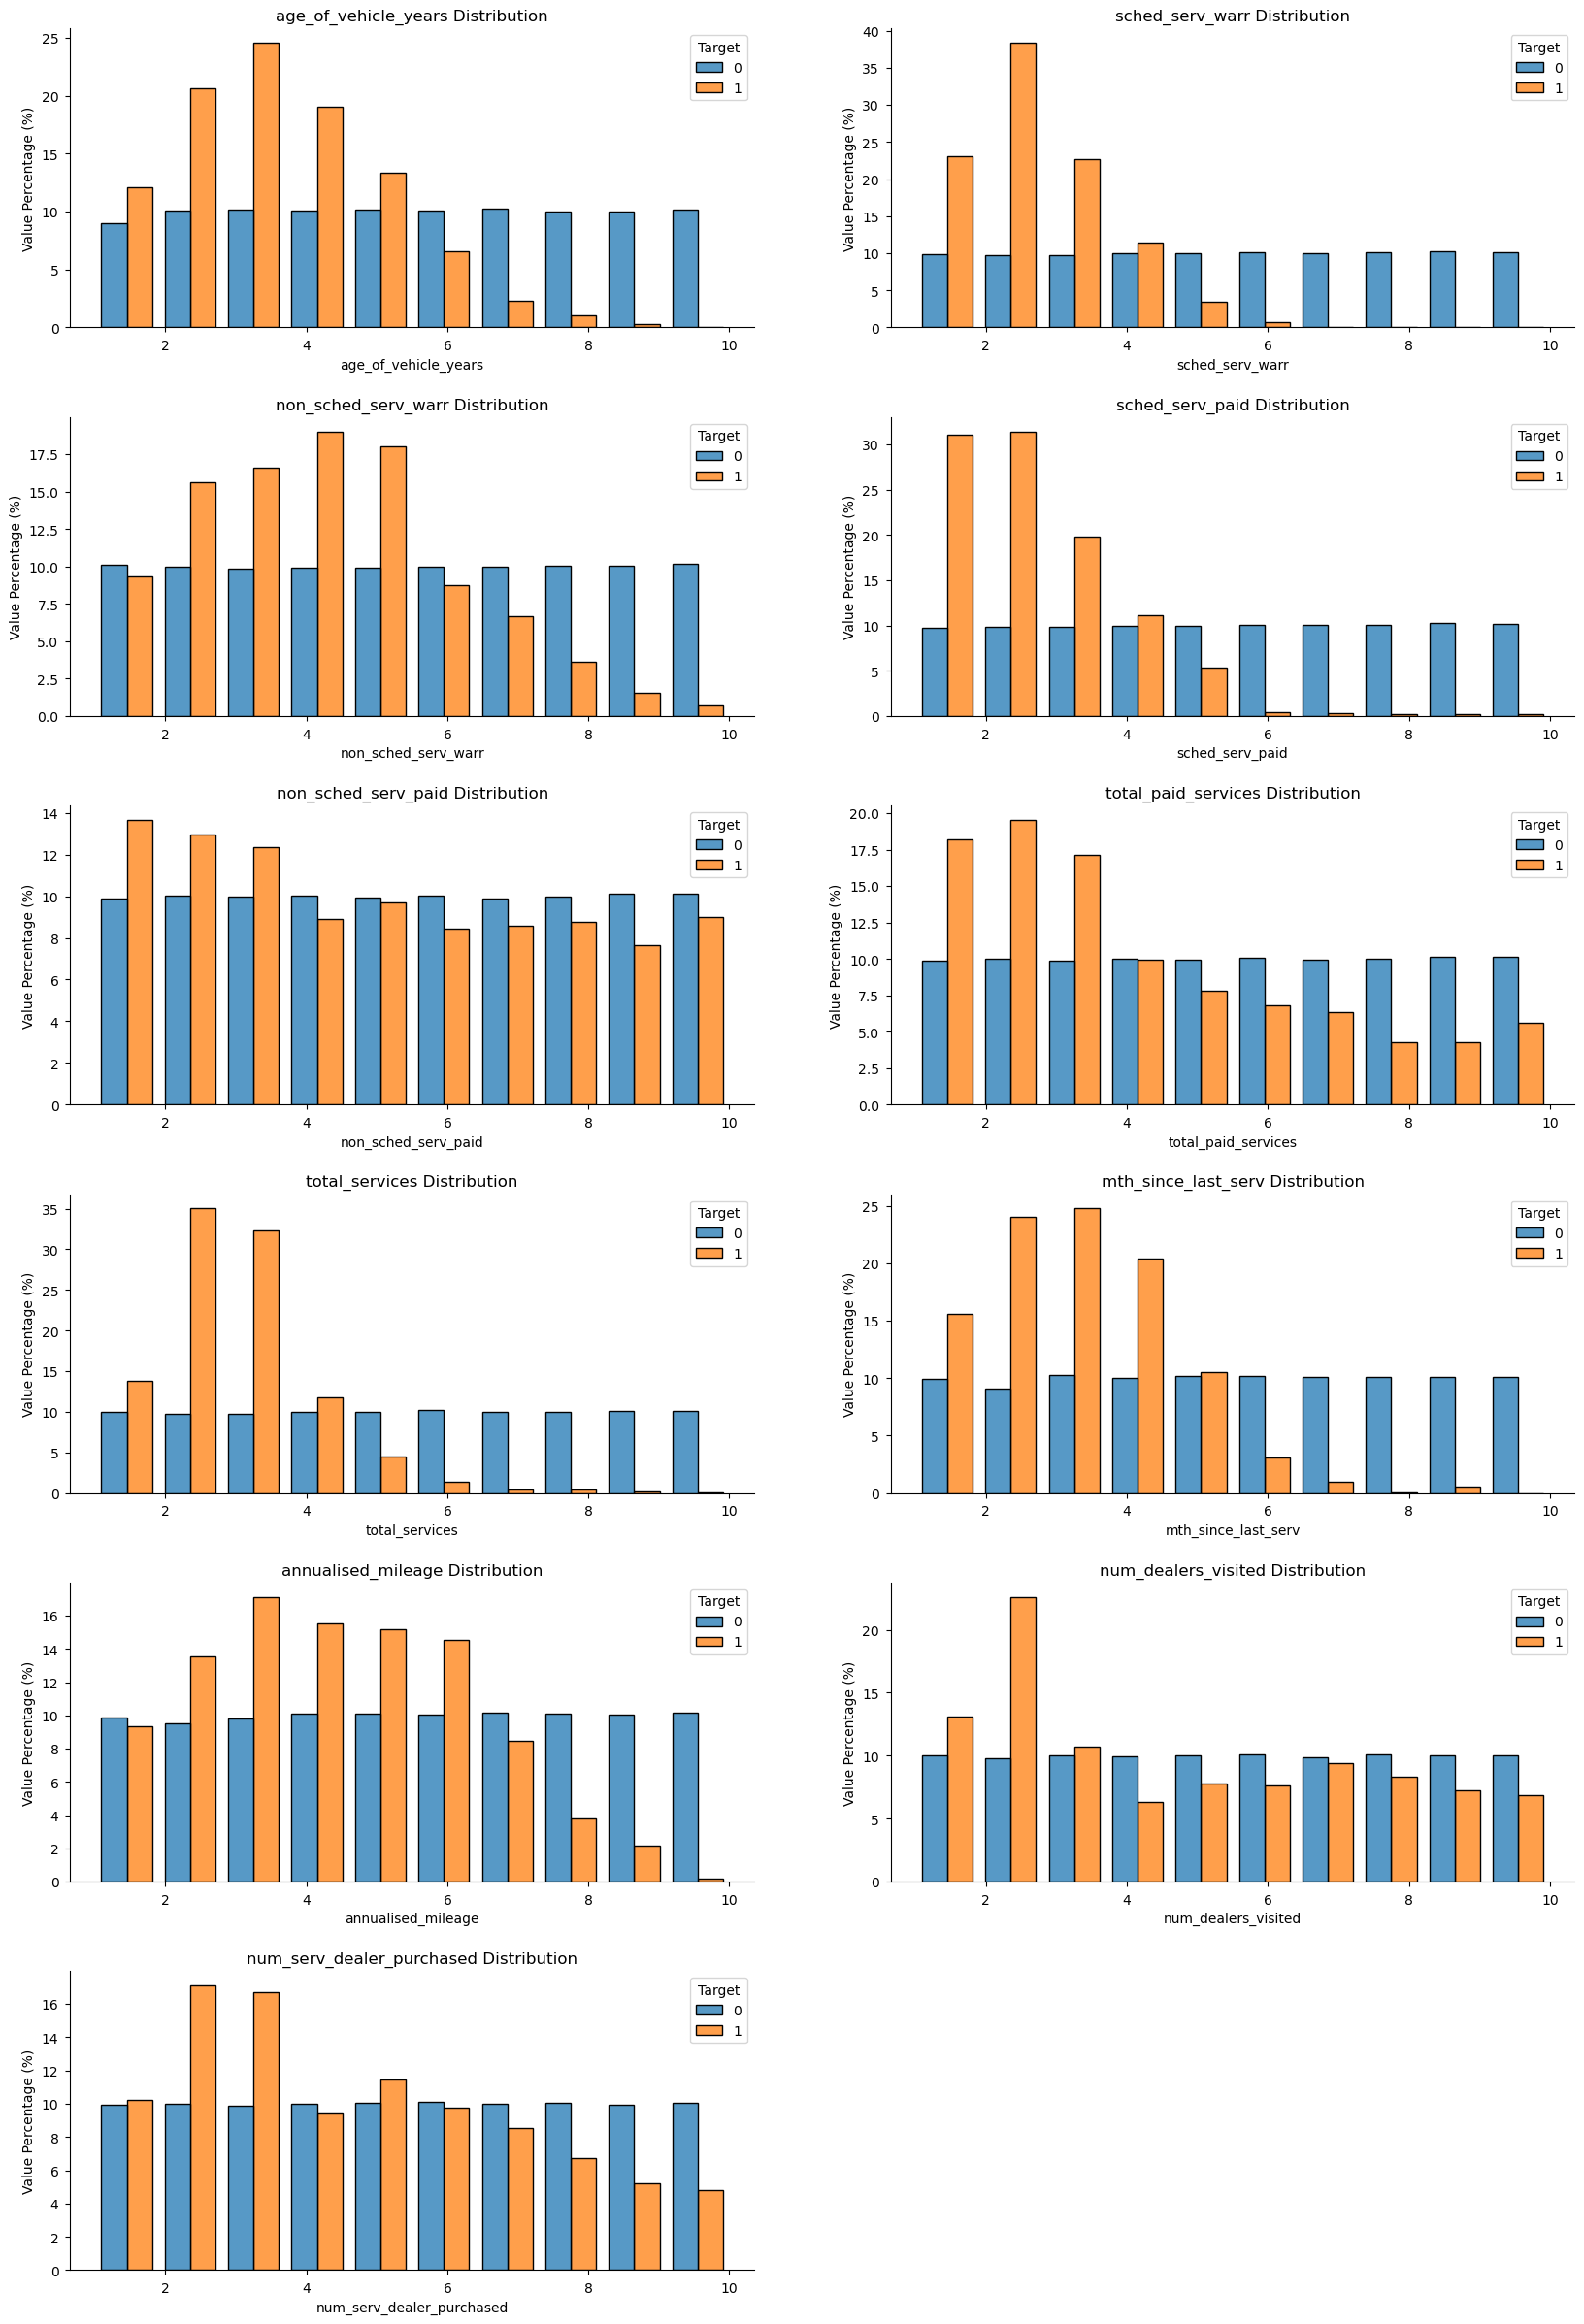

In [103]:
nrows = 6
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*5))

row_idx = 0
col_idx = 0

for feat in num_feats:
    if col_idx >= ncols:
        col_idx = 0
        row_idx += 1

    plot_hist(df, feat=feat, title=f'{feat} Distribution',
            xlabel=feat, ylabel='Value Percentage (%)', 
            bins=len(df[feat].unique()), mode='subplot', ax=axes[row_idx, col_idx])
    col_idx += 1

# # adjust distance between figures
plt.subplots_adjust(wspace=0.2,
                hspace=0.3)

fig.delaxes(axes[5,1])

Overall, cars with lower age, less scheduled services, total services, and months since last service are more likely to be re-bought by customers. We can better visualize the difference with boxplot later.

<Axes: >

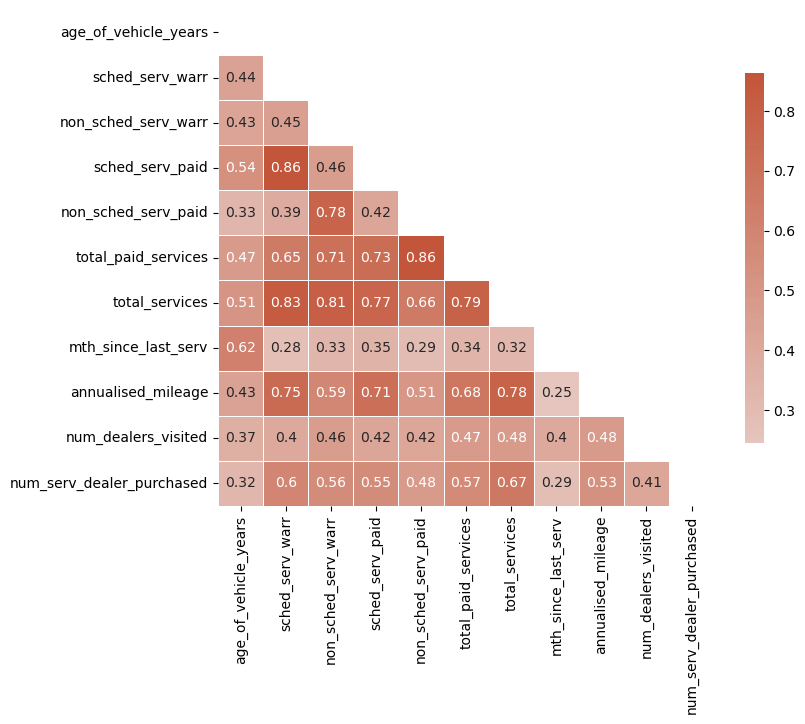

In [104]:
# sns.regplot(data=df, x='age', )
corr = df[num_feats].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(400, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap='crest', vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2")

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True, fmt=".2")

In [105]:
def plot_box_correlation(df, feat, target, figsize=(9, 3), title='', xlabel='', ylabel='', 
               ax='', mode='plot', order=[], ticklabels={}, x_rotation=0, y_rotation=0, 
               orientation='h', palette={}, width=1):
    
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize)

    # if order == []:
    #     order = list(set(df[feat].sort_values(ascending=True)))

    # # get new tick labels if available
    # ordered_ticklabels = [ticklabels[l] for l in order] if ticklabels != {} else order

    if orientation == 'v':
        sns.boxplot(data=df, x=feat, hue=target, ax=ax, width=width)
        ax.set_xticklabels(ticklabels=ticklabels, rotation=x_rotation)
        # Apply the custom formatting function to the y-axis
    else:
        sns.boxplot(data=df, y=feat, hue=target, ax=ax, width=width)
        ax.set_yticklabels(ticklabels=ticklabels, rotation=y_rotation)
        # Apply the custom formatting function to the y-axis

    custom_axes(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel) 

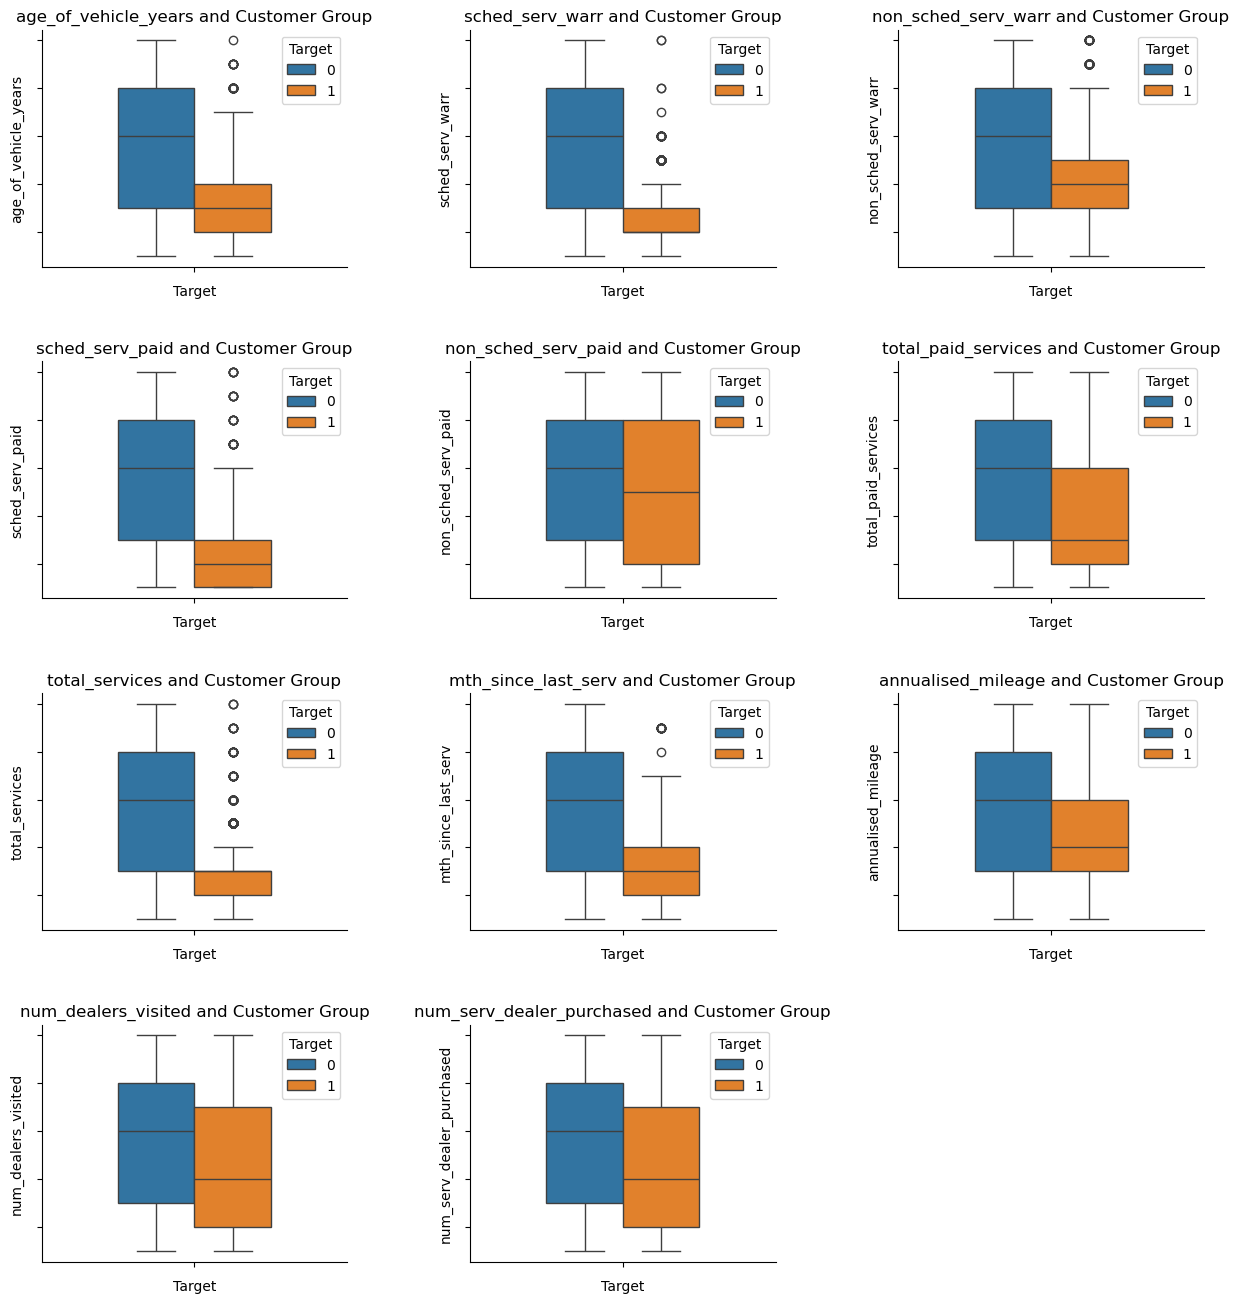

In [106]:
nrows = 4
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))

row_idx = 0
col_idx = 0

for feat in num_feats:
    if col_idx >= ncols:
        col_idx = 0
        row_idx += 1

    xtitle = target
    ytitle = feat
    prefix = f"{ytitle} and Customer Group"

    plot_box_correlation(df, feat=feat, target=target, orientation='h',
                        title=f"{prefix}", ylabel=ytitle, xlabel=xtitle, 
                        mode='subplot', ax=axes[row_idx, col_idx], width=0.5)
    col_idx += 1

# # adjust distance between figures
plt.subplots_adjust(wspace=0.4,
                hspace=0.4)

fig.delaxes(axes[3,2])


As can be seen from above, all variables witness a difference in distribution between 2 customer groups (rebuy and non-rebuy), which can be leveraged to build a robust classification model.

#### Summary

1. ***Categorical Features***: 

- Drop features with high missing values percentage (age band, gender)
- Other features (car model and car segment) can be leveraged for model building.

2. ***Numerical Features***:
- Can utilize all numerical features

### 5. Prepare Data

In [107]:
df_cleaned = df.copy()

In [149]:
# define used num feats and used cate feats
used_num_feats = num_feats
used_cate_feats = ['car_model', 'car_segment']

# features used as predictors
predictors = used_num_feats + used_cate_feats

X = df_cleaned[predictors]
y = df_cleaned[target]

### 6. Split Dataset

In [150]:
# Split data into training and testing sets

# split 20% for test data
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# split 20% of training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)

print(f'Train dataset: {X_train.shape} \t Positive Class Ratio: {round((y_train == 1).sum()/len(y_train)*100, 3)}%')
print(f'Val dataset: {X_val.shape} \t Positive Class Ratio: {round((y_val == 1).sum()/len(y_val)*100, 3)}%')
print(f'Test dataset: {X_test.shape} \t Positive Class Ratio: {round((y_test == 1).sum()/len(y_test)*100, 3)}%')


Train dataset: (78801, 13) 	 Positive Class Ratio: 2.681%
Val dataset: (26268, 13) 	 Positive Class Ratio: 2.68%
Test dataset: (26268, 13) 	 Positive Class Ratio: 2.68%


In [151]:
# identify unknown classes of categorical features in validation and test set
print('Validation set')
for feat in used_cate_feats:
    print(f'{feat}: {[val for val in X_val[feat].unique() if val not in X_train[feat].unique()]}') 
print('\nTest set')
for feat in used_cate_feats:
    print(f'{feat}: {[val for val in X_test[feat].unique() if val not in X_train[feat].unique()]}') 

Validation set
car_model: []
car_segment: []

Test set
car_model: []
car_segment: []


In [152]:
# identify unknown classes of categorical features in validation and test set
print('Validation set')
for feat in used_cate_feats:
    print(f'{feat}: {[val for val in X_val[feat].unique() if val not in X_train[feat].unique()]}') 
print('\nTest set')
for feat in used_cate_feats:
    print(f'{feat}: {[val for val in X_test[feat].unique() if val not in X_train[feat].unique()]}') 

Validation set
car_model: []
car_segment: []

Test set
car_model: []
car_segment: []


In [163]:
# from imblearn.over_sampling import SMOTENC, ADASYN
# from imblearn.combine import SMOTEENN
# from imblearn.under_sampling import EditedNearestNeighbours

# # get cate feat id in X_train
# cate_indices = [X_train.columns.get_loc(feat) for feat in X_train.columns]

# num_nonrebuy = (y_train == 0).sum()
# num_rebuy = (y_train == 1).sum()

# print('Before Balancing')
# print('Number of Non-Rebuy class:', num_nonrebuy)
# print('Number of Rebuy class:', num_rebuy)
# print('Rebuy/Non-Rebuy Ratio:', round(num_rebuy/num_nonrebuy*100, 2))

# smote_nc = SMOTENC(random_state=42, categorical_features=cate_indices)

# # Define and fit ADASYN
# adasyn = ADASYN(random_state=42, n_neighbors=5)  # Adjust n_neighbors as needed

# smote_enn = SMOTEENN(random_state=42, sampling_strategy='minority')


# # convert decimal features to categorical features
# X_train_copy = X_train.copy()
# for col in used_num_feats:
#     X_train_copy[feat] = X_train_copy[feat].astype(str)

# # X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train_copy, y_train)

# X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

# num_nonrebuy_balanced = (y_train_balanced == 0).sum()
# num_rebuy_balanced = (y_train_balanced == 1).sum()

# print('\nAfter Balancing')
# print('Number of Non-Rebuy class:', num_nonrebuy_balanced)
# print('Number of Rebuy class:', num_rebuy_balanced)
# print('Rebuy/Non-Rebuy Ratio:', round(num_rebuy_balanced/num_nonrebuy_balanced*100, 2))

### 7. Baseline Model

In [112]:
# create random predictions
train_baseline = np.random.randint(2, size=len(y_train))
val_baseline = np.random.randint(2, size=len(y_val))
test_baseline = np.random.randint(2, size=len(y_test))


In [113]:
def display_prec_recall_curve(model, X, y, model_name, title, ax=None):
    display = PrecisionRecallDisplay.from_estimator(
    model, X, y, name=model_name, ax=ax 
)
    _ = display.ax_.set_title(title)

def display_confusion_matrix(y_true, y_preds, title, ax=None):
    display = ConfusionMatrixDisplay.from_predictions(
        y_true, y_preds, normalize='true', ax=ax)
    _ = display.ax_.set_title(title)

In [114]:
recall = round(recall_score(y_train, train_baseline), 3)
f1 = round(f1_score(y_train, train_baseline), 3)
precision = round(precision_score(y_train, train_baseline), 3)

print(f'Train dataset: \tPrecision: {precision} \tRecall: {recall} \tF1 Score: {f1}')

recall = round(recall_score(y_val, val_baseline), 3)
f1 = round(f1_score(y_val, val_baseline), 3)
precision = round(precision_score(y_val, val_baseline), 3)

print(f'\nVal dataset: \tPrecision: {precision} \tRecall: {recall} \tF1 Score: {f1}')

recall = round(recall_score(y_test, test_baseline), 3)
f1 = round(f1_score(y_test, test_baseline), 3)
precision = round(precision_score(y_test, test_baseline), 3)

print(f'\nTest dataset: \tPrecision: {precision} \tRecall: {recall} \tF1 Score: {f1}')

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# # display_confusion_matrix(y_true=y_train, y_preds=train_baseline, 
# #                          title='Confusion Matrix for Train Baseline', ax=axes[0])
# # display_confusion_matrix(y_true=y_test, y_preds=test_baseline, 
# #                          title='Confusion Matrix for Test Baseline', ax=axes[1])

Train dataset: 	Precision: 0.028 	Recall: 0.52 	F1 Score: 0.053

Val dataset: 	Precision: 0.026 	Recall: 0.496 	F1 Score: 0.05

Test dataset: 	Precision: 0.027 	Recall: 0.5 	F1 Score: 0.051


### 8. Train Machine Learning Model

#### 8.1. Default KNN

##### Define utilizing functions

In [115]:
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    # Get predictions (assuming probability of positive class)
    pred_probs = model.predict_proba(X_test)[:, 1]
    return pred_probs

def get_optimize_thres(y_true, pred_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, pred_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = round(thresholds[best_threshold_idx], 3)
    return best_threshold

def eval(y_true, pred_probs, thres=0.5):
    preds = (pred_probs > thres).astype(int)

    recall = round(recall_score(y_true, preds), 3)
    f1 = round(f1_score(y_true, preds), 3)
    precision = round(precision_score(y_true, preds), 3)

    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'preds': preds}

def print_scores(scores):
    print(f"Precision: {scores['precision']} \t Recall: {scores['recall']} \t F1 Score: {scores['f1_score']}")

##### Training Default KNN model

In [164]:
# Define preprocessors for categorical and numerical features
categorical_preprocessor = OrdinalEncoder()
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, used_cate_feats),
        ("numerical", numerical_preprocessor, used_num_feats)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

# # preds on train data
# pred_probs_train = train_and_predict(pipeline, X_train, y_train, X_train)
# # preds on val data
# pred_probs_val = train_and_predict(pipeline, X_train, y_train, X_val)
# # preds on test data
# pred_probs_test = train_and_predict(pipeline, X_train, y_train, X_test)


# # calculate precision, recall and F1 score for only positive class
# print('Train Dataset')
# print('Default Threshold: 0.5')
# print_scores(eval(y_true=y_train, pred_probs=pred_probs_train))

# # calculate precision, recall and F1 score for only positive class
# print('\nVal Dataset')
# print('Default Threshold: 0.5')
# print_scores(eval(y_true=y_val, pred_probs=pred_probs_val))

# # calculate precision, recall and F1 score for only positive class
# print('\nTest Dataset')
# print('Default Threshold: 0.5')
# print_scores(eval(y_true=y_test, pred_probs=pred_probs_test))

# preds on train data
pred_probs_train = train_and_predict(pipeline, X_train, y_train, X_train)
# preds on val data
pred_probs_val = train_and_predict(pipeline, X_train, y_train, X_val)
# preds on test data
pred_probs_test = train_and_predict(pipeline, X_train, y_train, X_test)

# optimize classification threshold on val dataset
best_thres = get_optimize_thres(y_true=y_val, pred_probs=pred_probs_val)

# calculate precision, recall and F1 score for only positive class
print('Train Dataset')
print('Default Threshold: 0.5')
print_scores(eval(y_true=y_train, pred_probs=pred_probs_train))
print(f'Best Threshold: {best_thres}')
print_scores(eval(y_true=y_train, pred_probs=pred_probs_train, thres=best_thres))

# calculate precision, recall and F1 score for only positive class
print('\nVal Dataset')
print('Default Threshold: 0.5')
print_scores(eval(y_true=y_val, pred_probs=pred_probs_val))
print(f'Best Threshold: {best_thres}')
print_scores(eval(y_true=y_val, pred_probs=pred_probs_val, thres=best_thres))

# calculate precision, recall and F1 score for only positive class
print('\nTest Dataset')
print('Default Threshold: 0.5')
print_scores(eval(y_true=y_test, pred_probs=pred_probs_test))
print(f'Best Threshold: {best_thres}')
print_scores(eval(y_true=y_test, pred_probs=pred_probs_test, thres=best_thres))


Train Dataset
Default Threshold: 0.5
Precision: 0.953 	 Recall: 0.588 	 F1 Score: 0.727
Best Threshold: 0.4
Precision: 0.953 	 Recall: 0.588 	 F1 Score: 0.727

Val Dataset
Default Threshold: 0.5
Precision: 0.904 	 Recall: 0.506 	 F1 Score: 0.648
Best Threshold: 0.4
Precision: 0.904 	 Recall: 0.506 	 F1 Score: 0.648

Test Dataset
Default Threshold: 0.5
Precision: 0.897 	 Recall: 0.456 	 F1 Score: 0.605
Best Threshold: 0.4
Precision: 0.897 	 Recall: 0.456 	 F1 Score: 0.605


In [117]:
print('n_neighbors:', pipeline.get_params()['knn__n_neighbors'])
print('distance (1: mahattan, 2: euclidean):', pipeline.get_params()['knn__p'])
print('neighbor_weights:', pipeline.get_params()['knn__weights'])

n_neighbors: 5
distance (1: mahattan, 2: euclidean): 2
neighbor_weights: uniform


The model has very poor Recall scores on minority class due to imbalance problem. In order to address this problem, we will try to force the model to focus more on minority class by applying Cost Sensitive technique (applying more weight to minority class)

##### Applying Grid Search to optimize KNN model

In [118]:
# Define preprocessors for categorical and numerical features
categorical_preprocessor = OrdinalEncoder()
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, used_cate_feats),
        ("numerical", numerical_preprocessor, used_num_feats)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': range(1, 10),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_params

{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}

In [171]:
# Define preprocessors for categorical and numerical features
categorical_preprocessor = OrdinalEncoder()
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, used_cate_feats),
        ("numerical", numerical_preprocessor, used_num_feats)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_params['knn__n_neighbors'],
        p=best_params['knn__p'],
        weights=best_params['knn__weights']
    ))
])

# preds on train data
pred_probs_train = train_and_predict(pipeline, X_train, y_train, X_train)
# preds on val data
pred_probs_val = train_and_predict(pipeline, X_train, y_train, X_val)
# preds on test data
pred_probs_test = train_and_predict(pipeline, X_train, y_train, X_test)

# calculate precision, recall and F1 score for only positive class
print('Train Dataset')
print_scores(eval(y_true=y_train, pred_probs=pred_probs_train))

# calculate precision, recall and F1 score for only positive class
print('\nVal Dataset')
print_scores(eval(y_true=y_val, pred_probs=pred_probs_val))

# calculate precision, recall and F1 score for only positive class
print('\nTest Dataset')
print_scores(eval(y_true=y_test, pred_probs=pred_probs_test))



Train Dataset
Precision: 1.0 	 Recall: 1.0 	 F1 Score: 1.0

Val Dataset
Precision: 0.766 	 Recall: 0.54 	 F1 Score: 0.633

Test Dataset
Precision: 0.756 	 Recall: 0.518 	 F1 Score: 0.615


### 9. Assess Model Performance

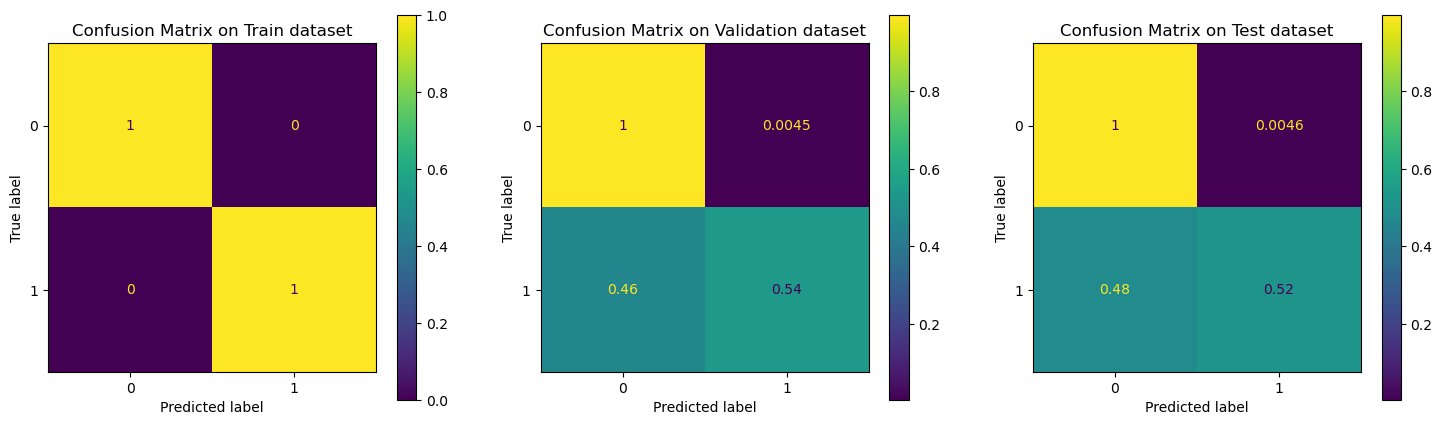

In [121]:
model_name = 'KNN'
prefix = "Confusion Matrix"

train_preds = eval(y_true=y_train, pred_probs=pred_probs_train)['preds']
val_preds = eval(y_true=y_val, pred_probs=pred_probs_val)['preds']
test_preds = eval(y_true=y_test, pred_probs=pred_probs_test)['preds']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

display_confusion_matrix(y_train, train_preds,
                          title=f"{prefix} on Train dataset", ax=axes[0])

display_confusion_matrix(y_val, val_preds,
                          title=f"{prefix} on Validation dataset", ax=axes[1])

display_confusion_matrix(y_test, test_preds,
                          title=f"{prefix} on Test dataset", ax=axes[2])

As can be seen from above figures, the model can capture around 54% of total re-buy customers. In other words, the model has identified 46% of re-buy customers as non-rebuy customers.